# Selection Functions and Number Counts

#### Using the depths maps for Lockman swire you can calculate the probability that a source of true flux f will be detected in each healpix
#### in the field with an associated error calculated in the depth map

In [172]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import scipy
from scipy.optimize import curve_fit
import scipy.stats
import pickle
import os
from pymoc import MOC
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import utils

In [199]:
a = np.array([0,0.3,0.7,1,1.1])
a>0.6

array([False, False,  True,  True,  True], dtype=bool)

In [2]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [3]:
@custom_model
def selection1(val, amp=10.9,x0=2.9,alpha=0.1, mean=3,sig=0.7):
    
    true_dist = np.log(amp) - alpha*(np.log((2.5/x0)*np.log(val)))
    gaus_cdf = np.log(0.5*(1 + scipy.special.erf((val - mean)/(np.sqrt(2)*sig))))
    return(true_dist + gaus_cdf)

In [4]:
@custom_model
def selection2(val, amp=10.9,x0=2.9,alpha=0.1, mean=3,sig=0.7):
    
    true_dist = amp * (-2.5*np.log(val)/x0)**alpha
    gaus_cdf = np.log(0.5*(1 + scipy.special.erf((val - mean)/(np.sqrt(2)*sig))))
    return(true_dist * gaus_cdf)

In [487]:
@custom_model
def power_gaus_cdf(val, amp=18,x0=18,alpha=-30, mean=22,sig=-0.7):
    
    power = amp*(val/x0)**-alpha
    gaus_cdf = 0.5*(1 + scipy.special.erf((val - mean)/(np.sqrt(2)*sig)))
    return(power * gaus_cdf)

In [437]:
@custom_model
def linear_gaus_cdf(val, amp=10.9,x0=2.9,alpha=0.1, mean=3,sig=0.7):
    
    linear = alpha*np.log(val/x0) + np.log(amp)
    gaus_cdf = 0.5*(1 + scipy.special.erf((val - mean)/(np.sqrt(2)*sig)))
    return(linear + np.log(gaus_cdf))

In [438]:
def linear(val,amp,x0,alpha):
    
    return(np.log(amp) + alpha*np.log(val/x0))

In [439]:
def power(val, amp,x0,alpha):
    
    return(amp*(val/x0)**-alpha)

In [9]:
def gaus_cdf(val, mean,sig):
    
    return(0.5*(1 + scipy.special.erf((val - mean)/(np.sqrt(2)*sig))))

In [10]:
def gaus_prob(errors, confidence, hist_errors):
    '''
    Returns the probability of a source of a given true flux being detected to a confidence level
    The fluxes used for this are in the range 0,98
    This is done assuming gaussian errors
    
    Parameters
    -----------
    Errors: a list of errors found in the field
    confidence: a integer, the confidence level you are working at eg 2/3/4 sigma
    hist_errors: a list of the number of regions of your field that have an error given in errors
    
    Returns
    ---------
    Prob: the probability that a source of given flux will be detected in the field averaged across
    all the regions in the field
    '''
    
    prob = np.zeros(len(hist_errors))
    cutoff = np.zeros(len(hist_errors))
    true_flux = np.arange(0,len(hist_errors),1)
    
    cutoffs = confidence * errors
    
    for n in range(len(errors)):
        prob = prob + (1 - scipy.stats.norm(np.array(true_flux),errors[n]).cdf(cutoffs[n]))*hist_errors[n]
    return(prob/sum(hist_errors))

In [183]:
def gaus_mag_prob(errors, confidence, hist_errors, mag_hist):
    '''
    Returns the probability of a source of a given magnitude being detected to a given confidence level
    The magnitudes used for this are in the range 15,30 divided in 98 increments
    This is done assuming gaussian errors
    
    Parameters
    -----------
    Errors: a list of errors found in the field
    confidence: a integer, the confidence level you are working at eg 2/3/4 sigma
    hist_errors: a list of the number of regions of your field that have an error given in errors
    
    Returns
    ---------
    Prob: the probability that a source of given flux will be detected in the field averaged across
    all the regions in the field
    '''
    print(len(mag_hist))
    
    prob = np.zeros(len(hist_errors))
    cutoff = np.zeros(len(hist_errors))
    true_flux = np.arange(0,len(hist_errors),1)
    
    fluxes,_ = utils.mag_to_flux(mag_hist)
    
    cutoffs = confidence * errors
    
    for n in range(len(errors)):
        prob = prob + ((scipy.stats.norm(np.array(true_flux),errors[n]).cdf(cutoffs[n])) )*hist_errors[n]
    return(prob/sum(hist_errors))

In [180]:
def poissson_prob(errors,confidence,hist_errors):
   
    errors = errors
    prob = np.zeros(len(hist_errors))
    cutoff = np.zeros(len(hist_errors))
    true_flux = np.arange(0,len(hist_errors),1)

    cutoffs = confidence * errors
    
    for n in range(len(errors)):
        prob = prob + (1 - scipy.stats.poisson.cdf(cutoffs[n],np.array(true_flux)))*hist_errors[n]
    return(prob/sum(hist_errors))

In [114]:
def selection_plot(lockman_flux,true_flux,prob,confidence):
    '''
    plots the selection effects
    the blue line is the probability that a source of that flux is detected
    the orange line is the number of sources detected with that flux in Lockman-SWIRE
    the red line is the predicted number distribution of sources of a given flux calculated 
    by number of detected sources / probability of detection
    the green line shows the shape of the number distribution you would expect if the real 
    observed sources were the true distribution of real sources. This is calculated by
    number of real sources * probability of detection
    '''

    bin_list_flux = np.linspace(0.001,100.0,1001)

    mask = ~np.isnan(lockman_flux)
    lockman_flux = lockman_flux[mask]
    
    lockman_hist, _ = np.histogram(lockman_flux,bin_list_flux)

    lockman_hist_log = np.log(lockman_hist)
    
    true_flux_new = np.arange(0,100,0.1)
    prob_interp = np.interp(true_flux_new,true_flux,prob)

    plt.plot(true_flux_new,prob_interp,color='blue')
    plt.plot(true_flux_new,lockman_hist_log,color='orange')
    error = np.sqrt(lockman_hist) /  lockman_hist * lockman_hist_log
    plt.errorbar(true_flux_new,lockman_hist_log,yerr=error,color='orange',alpha=0.6)
    plt.plot(true_flux_new,(lockman_hist_log*(prob_interp)),color='green')
    plt.plot(true_flux_new,(lockman_hist_log/(prob_interp)),color='red')
    plt.plot([0,110] , [1,1],c='black',alpha=0.6)
    plt.plot(true_flux_new,gaus_cdf(true_flux_new,2,1))
    plt.xlim(-0.2,25)
    plt.ylim(-0.1,15)
    plt.title('selection effects at {} sigma level'.format(confidence))
    plt.xlabel('True flux (mJy)')
    plt.ylabel('number counts / probability')
    blue_patch = patches.Patch(color='blue', label='probability of detection')
    green_patch = patches.Patch(color='green', label='number of expected detections')
    orange_patch = patches.Patch(color='orange', label='distribution of real IRAC sources')
    red_patch = patches.Patch(color='red', label='predicted true distribution of sources')
    plt.legend(handles=[blue_patch,orange_patch,green_patch,red_patch])
    plt.show()
    return(true_flux_new,prob_interp,lockman_hist_log,error)

### Load in the depth map and data for Lockman-SWIRE

In [13]:
depth_lockman = Table.read('../dmu1/dmu1_ml_Lockman-swire/data/depths_lockman-swire20171201.fits')
lockman_data = Table.read('../dmu1/dmu1_ml_Lockman-swire/data/master_catalogue_lockman-swire_20170710.fits')
SERVS_data = Table.read('../dmu1/dmu1_ml_Lockman-swire/data_tmp/SERVS.fits')
depth_lockman_SERVS = Table.read('../dmu1/dmu1_ml_Lockman-swire/data/depths_lockman-swire_SERVS.fits')
SWIRE_data = Table.read('../dmu1/dmu1_ml_Lockman-swire/data_tmp/SWIRE.fits')
depth_lockman_SWIRE = Table.read('../dmu1/dmu1_ml_Lockman-swire/data/depths_lockman-swire_SWIRE.fits')
paplovich_irac = Table.read('data/irac1_number_counts_Papovich2016.fits')

/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


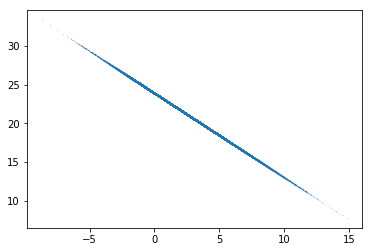

In [14]:
plt.scatter(np.log(lockman_data['f_irac1']),lockman_data['m_irac1'],s=0.01)
plt.show()

### load in the data from CDFS-SWIRE for the CANDELS data

In [15]:
cdfs_data = Table.read('../dmu1/dmu1_ml_CDFS-SWIRE/data/master_catalogue_cdfs-swire_20180122.fits')

/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


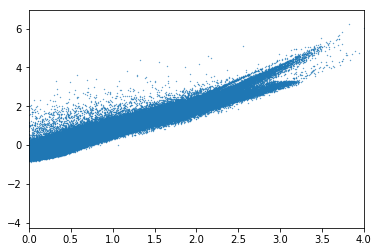

In [16]:
plt.scatter(np.log10(lockman_data['f_irac1']/lockman_data['ferr_irac1']),np.log10(lockman_data['f_irac1']),s=0.1)
plt.xlim(0,4)
plt.show()

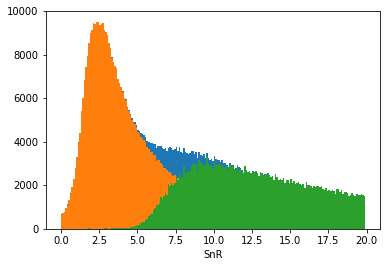

In [17]:
mask1 = [~(np.isnan(lockman_data['f_irac1']) | np.isnan(lockman_data['ferr_irac1']))]
plt.hist((lockman_data['f_irac1'][mask1]/lockman_data['ferr_irac1'][mask1]),bins=np.arange(0,20,0.1))
mask2 = [~(np.isnan(SERVS_data['f_servs_irac1']) | np.isnan(SERVS_data['ferr_servs_irac1']))]
plt.hist((SERVS_data['f_servs_irac1'][mask2]/SERVS_data['ferr_servs_irac1'][mask2]),bins=np.arange(0,20,0.1))
mask3 = [~(np.isnan(SWIRE_data['f_swire_irac1']) | np.isnan(SWIRE_data['ferr_swire_irac1']))]
plt.hist((SWIRE_data['f_swire_irac1'][mask3]/SWIRE_data['ferr_swire_irac1'][mask3]),bins=np.arange(0,20,0.1))
#plt.ylim(0,10000)
plt.xlabel('SnR')
plt.show()

In [18]:
sel = np.isnan(depth_lockman['ferr_irac_i1_mean'])
lockman_error = depth_lockman['ferr_irac_i1_mean'][~sel]
sel = np.isnan(depth_lockman_SERVS['ferr_servs_irac1_mean'])
lockman_error_SERVS = depth_lockman_SERVS['ferr_servs_irac1_mean'][~sel]
sel = np.isnan(depth_lockman_SWIRE['ferr_swire_irac1_mean'])
lockman_error_SWIRE = depth_lockman_SWIRE['ferr_swire_irac1_mean'][~sel]

In [19]:
#since there is a row for each healpix cell of order 13 and the ferr is the average error
#across the order 10 healpix there are 63 duplicate ferr for each order 10 healpix that can be removed
lockman_error = np.unique(lockman_error)
lockman_error_SERVS = np.unique(lockman_error_SERVS)
lockman_error_SWIRE = np.unique(lockman_error_SWIRE)
print('number of rows in the lockman depth map = {}'.format(len(lockman_error)))
print('number of rows in the lockman depth map for servs data = {}'.format(len(lockman_error_SERVS)))
print('number of rows in the lockman depth map for swire data = {}'.format(len(lockman_error_SWIRE)))

number of rows in the lockman depth map = 3540
number of rows in the lockman depth map for servs data = 1854
number of rows in the lockman depth map for swire data = 3516


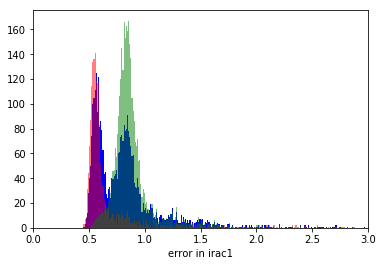

In [20]:
plt.hist(lockman_error,bins=np.arange(0,10,0.01),color='blue')
plt.hist(lockman_error_SERVS,bins=np.arange(0,10,0.01),alpha=0.5,color='red')
plt.hist(lockman_error_SWIRE,bins=np.arange(0,10,0.01),alpha=0.5,color='green')
plt.xlim(0,3)
plt.xlabel('error in irac1')
plt.show()

/Users/ianmccheyne/Documents/phd/dmu_products/dmu8/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


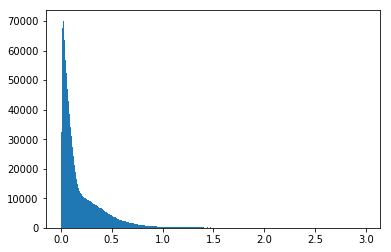

In [203]:
_,err = utils.flux_to_mag(lockman_data['f_irac1']*10**-6,lockman_data['ferr_irac1']*10**-6)
mask = ~np.isnan(err)
plt.hist(err[mask],bins=np.arange(0,3,0.01))
plt.show()

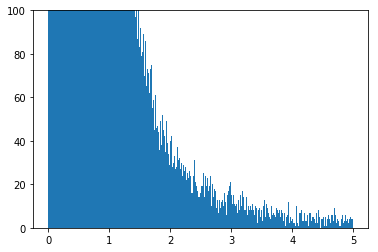

In [134]:
bins = np.arange(0,5,0.01)
plt.hist(lockman_data['merr_irac1'][~np.isnan(lockman_data['merr_irac1'])],bins=bins)
#plt.plot(paplovich_irac['m_ab'],paplovich_irac['dn/dm_ab'])
plt.ylim(0,100)
plt.show()

#### create a histogram of the errors in flux in the range 0,10

In [26]:
true_flux = np.arange(0,99,1)
lockman_irac_flux = lockman_data['f_irac1']
lockman_irac_mag = lockman_data['m_irac1']
lockman_SERVS_irac_flux = SERVS_data['f_servs_irac1']
lockman_SERVS_irac_mag = SERVS_data['m_servs_irac1']
lockman_SWIRE_irac_flux = SWIRE_data['f_swire_irac1']
lockman_SWIRE_irac_mag = SWIRE_data['m_swire_irac1']

bin_list_error = np.arange(0,10,0.1)
lockman_error_hist = np.histogram(lockman_error,bin_list_error)
lockman_error_SERVS_hist = np.histogram(lockman_error_SERVS,bin_list_error)
lockman_error_SWIRE_hist = np.histogram(lockman_error_SWIRE,bin_list_error)
center_bins = get_center(bin_list_error)
len(center_bins)

99

#### create a histogram of the errors in magnitude in the range 0,5

In [184]:
lockman_mag = lockman_data['m_irac1']
lockman_mag_error = lockman_data['merr_irac1']

true_mag = np.arange(10,30+20/99,20/99)
bin_list_error = np.arange(0,5,0.05)
mask = ~(np.isnan(lockman_data['m_irac1']))
lockman_mag = np.histogram(lockman_mag[mask],bins=true_mag)
mask = ~(np.isnan(lockman_data['merr_irac1']))
lockman_mag_error_hist = np.histogram(lockman_data['merr_irac1'][mask],bins=bin_list_error)
center_mag_bins = get_center(bin_list_error)

In [186]:
print(center_mag_bins)

[ 0.025  0.075  0.125  0.175  0.225  0.275  0.325  0.375  0.425  0.475
  0.525  0.575  0.625  0.675  0.725  0.775  0.825  0.875  0.925  0.975
  1.025  1.075  1.125  1.175  1.225  1.275  1.325  1.375  1.425  1.475
  1.525  1.575  1.625  1.675  1.725  1.775  1.825  1.875  1.925  1.975
  2.025  2.075  2.125  2.175  2.225  2.275  2.325  2.375  2.425  2.475
  2.525  2.575  2.625  2.675  2.725  2.775  2.825  2.875  2.925  2.975
  3.025  3.075  3.125  3.175  3.225  3.275  3.325  3.375  3.425  3.475
  3.525  3.575  3.625  3.675  3.725  3.775  3.825  3.875  3.925  3.975
  4.025  4.075  4.125  4.175  4.225  4.275  4.325  4.375  4.425  4.475
  4.525  4.575  4.625  4.675  4.725  4.775  4.825  4.875  4.925]


99


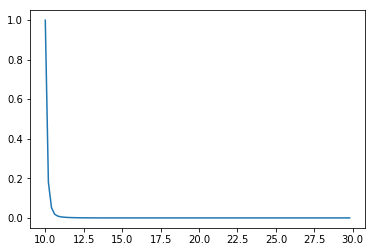

In [185]:
probg_mag = gaus_mag_prob(center_mag_bins,3,lockman_mag_error_hist[0],lockman_mag[0])
plt.plot(true_mag[:99],probg_mag)
plt.show()

In [51]:
servs_area = 5.929
swire_area = 11.76
area_ratio = swire_area/servs_area

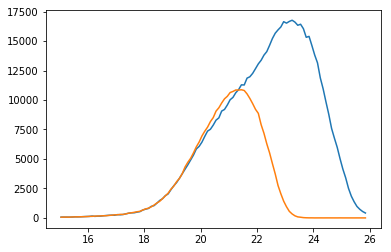

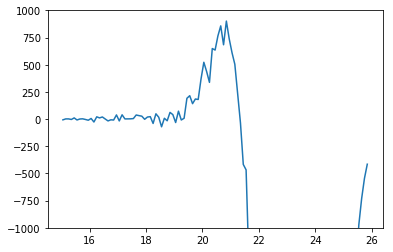

In [124]:
bins = np.arange(15,26,0.1)
bin_cent = get_center(bins)

mask = ~(np.isnan(SERVS_data['m_servs_irac1']))
plotting_servs = np.histogram(SERVS_data['m_servs_irac1'][mask],bins=bins)
plt.plot(bin_cent,plotting_servs[0])

mask = ~(np.isnan(SWIRE_data['m_swire_irac1']))
plotting_swire = np.histogram(SWIRE_data['m_swire_irac1'][mask],bins=bins)
plt.plot(bin_cent,plotting_swire[0]/area_ratio)
plt.show()

plt.plot(bin_cent,plotting_swire[0]/area_ratio - plotting_servs[0])
plt.ylim(-1000,1000)
plt.show()

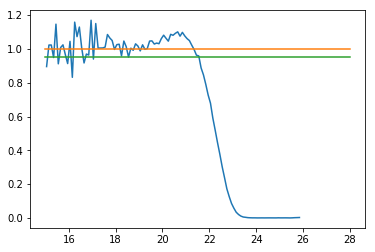

In [56]:
completeness = (plotting_swire[0]/area_ratio) / (plotting_servs[0])
plt.plot(bin_cent,completeness)
plt.plot([15,28],[1,1])
plt.plot([15,28],[0.95,0.95])
plt.show()

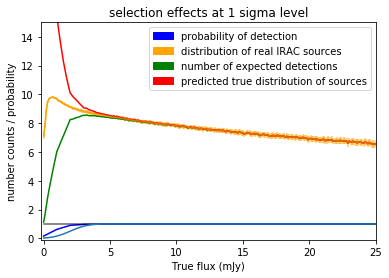

In [349]:
probg = gaus_prob(center_bins,1,lockman_error_hist[0])
true_flux_new, prob_interp, lockman_hist_log, lockman_hist_log_error = selection_plot(lockman_data['f_irac1'],true_flux,probg,1)

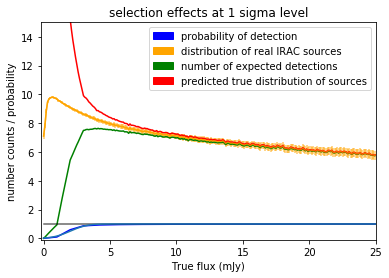

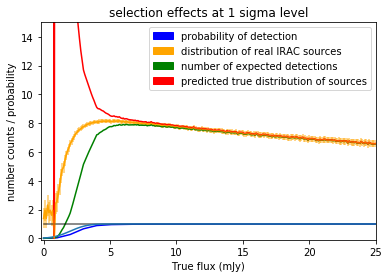

In [350]:
probg1 = gaus_prob(center_bins,3,lockman_error_SERVS_hist[0])
true_flux_new_servs, prob_interp_servs, lockman_hist_log_servs, lockman_hist_log_servs_error = selection_plot(SERVS_data['f_servs_irac1'],true_flux,probg1,1)
probg2 = gaus_prob(center_bins,3,lockman_error_SWIRE_hist[0])
true_flux_new_swire, prob_interp_swire, lockman_hist_log_swire, lockman_hist_log_swire_error = selection_plot(SWIRE_data['f_swire_irac1'],true_flux,probg2,1)

In [411]:
print (lockman_hist_log_swire[:12])
lockman_hist_log_swire[8] = np.interp(0.5,[0,1],[1.9459,2.3979])
lockman_hist_log_swire_error[8] = np.interp(0.5,[0,1],[lockman_hist_log_swire_error[7],lockman_hist_log_swire_error[9]])

[ 1.38629436  1.94591015  1.38629436  2.30258509  1.79175947  1.94591015
  1.60943791  1.94591015  2.1719      2.39789527  2.56494936  3.09104245]


[ 1.94591015  1.38629436  2.30258509  1.79175947  1.94591015  1.60943791
  1.94591015  2.1719      2.39789527  2.56494936  3.09104245]


/Users/ianmccheyne/Documents/phd/dmu_products/dmu8/utils.py:76: RuntimeWarning: divide by zero encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


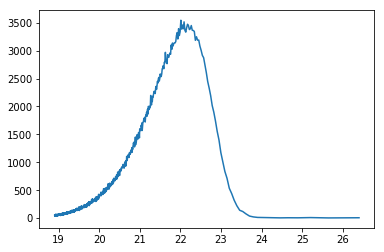

Model: power_gaus_cdf
Inputs: ('val',)
Outputs: ('val',)
Model set size: 1
Parameters:
         amp            x0          alpha           mean           sig      
    ------------- ------------- -------------- ------------- ---------------
    19.5880726899 17.9721431886 -28.0096886964 22.1512532992 -0.567391098765


/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


In [489]:
#lockman_hist_log_swire[8] = 2.1
maskx = true_flux_new > 0
true_mag_new,_ = utils.flux_to_mag(true_flux_new*10**-6)
#true_mag_new = 40-true_mag_new
#true_flux_new = true_flux_new[: :-1]
lockman_hist_swire = np.exp(lockman_hist_log_swire)
#maskx = true_mag_new <21

m_init = power_gaus_cdf()
#m_init = models.PowerLaw1D(40,19,1)
fit = fitting.LevMarLSQFitter()
#m = fit(m_init,true_flux_new[maskx], lockman_hist_log_swire[maskx],weights = 1/error[maskx])
print(lockman_hist_log_swire[:12][maskx[:12]])
plt.plot(true_mag_new[maskx],lockman_hist_swire[maskx])
plt.show()
m = fit(m_init,true_mag_new[maskx], lockman_hist_swire[maskx])
#m = fit(m_init,-true_mag_new[maskx], lockman_hist_swire[maskx],weights = 1/lockman_hist_log_swire_error[maskx])
m_param = m.parameters

print(m)
#print(true_mag_new[~maskx])

In [490]:
powerval = power(true_mag_new,m_param[0],m_param[1],m_param[2])
powval = power(np.arange(18.5,26,0.1),18.,18,-30)
#linearval = linear(true)
gaus_cdfval = gaus_cdf(true_mag_new,m_param[3],m_param[4])
gausval = gaus_cdf(np.arange(18.5,26,0.1),22,-0.7)

/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


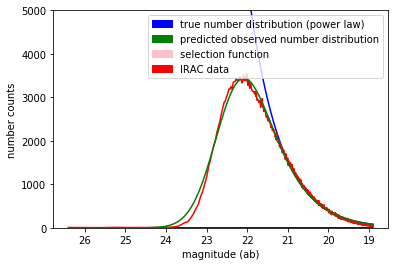

In [496]:
#plt.plot(true_flux_new,p(true_flux_new)-np.log(2),color='red')
#plt.plot(true_flux_new,prob_interp_swire,color='orange')
plt.plot(true_mag_new,powerval,color='blue')
plt.plot(true_mag_new,gaus_cdfval,color='blue')
#plt.plot(np.arange(18.5,26,0.1),gausval,color='pink')
#plt.plot(np.arange(18.5,26,0.1),powval,color='pink')
#plt.plot(np.arange(18.5,26,0.1),gausval*m(np.arange(18.5,26,0.1)),color='green')
#plt.plot(true_flux_new,prob_interp_swire*(p(true_flux_new)-np.log(2)),color='blue')
plt.plot(true_mag_new,lockman_hist_swire,color='red')
#plt.errorbar(-true_flux_new,lockman_hist_swire,yerr=lockman_hist_log_swire_error,color='pink',alpha=0.6)
plt.plot(true_mag_new,m(true_mag_new),color='green')
plt.gca().invert_xaxis()
#plt.xlim(0,3)
plt.ylim(0,5000)
plt.xlabel('magnitude (ab)')
plt.ylabel('number counts')

blue_patch = patches.Patch(color='blue', label='true number distribution (power law)')
green_patch = patches.Patch(color='green', label='predicted observed number distribution')
pink_patch = patches.Patch(color='pink',label='selection function')
red_patch = patches.Patch(color='red', label='IRAC data')
plt.legend(handles=[blue_patch,green_patch,pink_patch,red_patch])

In [484]:
utils.flux_to_mag(14*10**-6)

(21.034679910804407, None)

In [509]:
print(gaus_cdfval[140])
print(true_mag_new[140])

0.975460678386
21.0346799108


/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


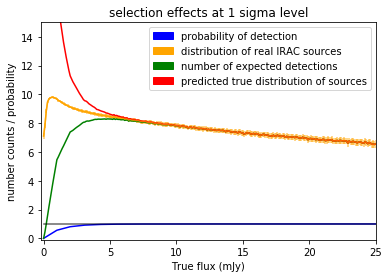

In [113]:
probp = poissson_prob(center_bins,1,lockman_error_hist[0])
_,_,_,_ = selection_plot(lockman_data['f_irac1'],true_flux,probp,1)

In [ ]:
plt.plot(true_flux,probg,c='red')
plt.plot(true_flux,probp,c='blue')
plt.xlim(-0.2,10)
plt.ylim(0,1.03)
plt.show()

In [ ]:
prob = gaus_prob(center_bins,2,lockman_error_hist[0])
selection_plot(lockman_data['f_irac1'],true_flux,prob,2)

In [ ]:
prob = poissson_prob(center_bins,2,lockman_error_hist[0])
selection_plot(lockman_data['f_irac1'],true_flux,prob,2)

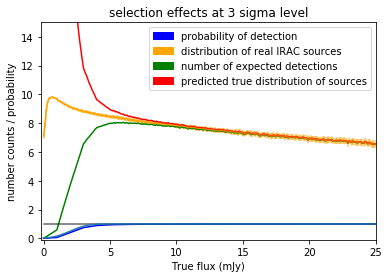

In [117]:
prob = gaus_prob(center_bins,3,lockman_error_hist[0])
_,_,_,_ = selection_plot(lockman_data['f_irac1'],true_flux,prob,3)

In [ ]:
prob = gaus_prob(center_bins,4,lockman_error_hist[0])
selection_plot(lockman_data['f_irac1'],true_flux,prob,4)

In [ ]:
prob = gaus_prob(center_bins,5,lockman_error_hist[0])
selection_plot(lockman_data['f_irac1'],true_flux,prob,5)

In [ ]:
cdfs_data.colnames

In [ ]:
irac_cdfs = cdfs_data['f_irac_i1']

In [ ]:
len(irac_cdfs)

In [ ]:
sum(np.isnan(irac_cdfs))

In [ ]:
sum(irac_flux!=0.0001)

In [ ]:
plt.scatter(cdfs_data['ra'],cdfs_data['dec'])
plt.show()

In [ ]:
plt.scatter(irac_data['ra'],irac_data['dec'])
plt.show()

In [ ]:
sum(cdfs_data['dec']>-29)

In [ ]:
s1 = cdfs_data['dec']>-29
s2 = cdfs_data['dec']<-27
s3 = cdfs_data['ra']>52
s4 = cdfs_data['ra']<54
cdfs_sel = s1&s2&s3&s4

In [ ]:
num_cdfs = len(cdfs_data[cdfs_sel])
den_cdfs = num_cdfs/(4)
print(den_cdfs)

In [ ]:
s1 = irac_data['ra']>159
s2 = irac_data['ra']<164
s3 = irac_data['dec']>57
s4 = irac_data['dec']<59
lockman_sel = s1&s2&s3&s4

In [ ]:
num_lockman = len(irac_data[lockman_sel])
den_lockman = num_lockman/(10)
print(den_lockman)

In [ ]:
bin_list = np.linspace(0.001,100.0,1001)
bin_list
irac_data_sel = irac_data[lockman_sel]
irac_flux = irac_data_sel['f_irac1']
for n in range(len(irac_flux)):
    if np.isnan(irac_flux[n]) == True or irac_flux[n] <=0:
        irac_flux[n] = 0.0001
    
irac_hist, _ = np.histogram(irac_flux,bin_list)

In [ ]:
irac_hist_log = np.log(irac_hist)
for n in range(len(irac_hist_log)):
    if irac_hist_log[n] <= 0:
        irac_hist_log[n] = 0.01

In [ ]:
bin_list = np.linspace(0.001,100.0,1001)
bin_list
cdfs_data_sel = cdfs_data[cdfs_sel]
cdfs_flux = cdfs_data_sel['f_irac_i1']
for n in range(len(cdfs_flux)):
    if np.isnan(cdfs_flux[n]) == True or cdfs_flux[n] <=0:
        cdfs_flux[n] = 0.0001
    
cdfs_hist, _ = np.histogram(cdfs_flux,bin_list)

In [ ]:
len(cdfs_data_sel)

In [ ]:
cdfs_hist_log = np.log(cdfs_hist)
for n in range(len(cdfs_hist_log)):
    if cdfs_hist_log[n] <= 0:
        cdfs_hist_log[n] = 0.01

In [ ]:
factor = np.log(den_cdfs/den_lockman)
factor

In [ ]:
plt.plot(bin_list[:1000],cdfs_hist_log+factor,c='red')
plt.plot(bin_list[:1000],irac_hist_log,c='blue')
plt.xlabel('Observed flux (micro Jy)')
plt.ylabel('log(number counts)')
plt.show()

In [ ]:
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)

In [ ]:
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)


In [ ]:
print(g)